In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as p
from scipy.stats import norm, spearmanr
import tensorflow as tf
import tensorflow_probability as tfp
import time
tfd = tfp.distributions

# Topic #1 - Easy/fast/flexible construction of multivariate continuous distributions using monotonic splines and copulas

In [2]:
# univariate density class
class UVDist:

    def __init__(self, pair_dict, tol=1e-10):
        assert len(pair_dict) >= 3
        assert all([isinstance(i, float) for i in pair_dict.keys()])
        assert all([isinstance(i, float) for i in pair_dict.values()])
        self.y = np.array(sorted(pair_dict.keys()))
        self.x = np.array([pair_dict[y] for y in self.y])
        self.h = np.diff(self.x)
        assert (self.y.min() == 0.) & (self.y.max() == 1.) & (self.h.min() > 0.)
        self.delta = np.diff(self.y) / self.h
        a = 1. / (self.h * self.delta)
        b = self.delta[:-1] / self.h[:-1] + self.delta[1:] / self.h[1:]
        c = 1. / self.h[:-1] + 1. / self.h[1:]
        d = np.zeros((2 + len(c),))
        condition = True
        while condition:
            _d = (c - a[:-1] * d[:-2] - a[1:] * d[2:]) ** 2
            _d += 4 * (a[:-1] + a[1:]) * b
            _d **= 0.5
            _d += c - a[:-1] * d[:-2] - a[1:] * d[2:]
            _d /= (2 * (a[:-1] + a[1:]))
            d[1:-1] = _d
            condition = np.abs(d[1:-1] - _d).max() > tol
        self.d = d

    def _cdf(self, x):
        idx = (self.x[:-1] <= x) & (self.x[1:] > x)
        if ~np.any(idx):
            if x >= self.x[-1]:
                return 1.
            else:
                return 0.
        theta = (x - self.x[:-1]) / self.h
        top = self.y[1:] * theta ** 2
        top += (self.y[1:] * self.d[:-1] + self.y[:-1] * self.d[1:]) / self.delta * theta * (1 - theta)
        top += self.y[:-1] * (1 - theta) ** 2
        bottom = theta ** 2
        bottom += (self.d[:-1] + self.d[1:]) / self.delta * theta * (1 - theta)
        bottom += (1 - theta) ** 2
        y = top / bottom
        return y[idx]

    def _icdf(self, y):
        assert (y >= 0) & (y <= 1)
        idx = (self.y[:-1] <= y) & (self.y[1:] > y)
        if ~np.any(idx):
            if y >= 1:
                return self.x[-1]
            else:
                return self.x[0]
        a = y * (2 - (self.d[:-1] + self.d[1:]) / self.delta)
        a -= self.y[:-1] + self.y[1:] - (self.y[1:] * self.d[:-1] + self.y[:-1] * self.d[1:]) / self.delta
        b = y * ((self.d[:-1] + self.d[1:]) / self.delta - 2)
        b -= (self.y[1:] * self.d[:-1] + self.y[:-1] * self.d[1:]) / self.delta - 2 * self.y[:-1]
        c = y - self.y[:-1]
        theta = -(b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
        x = theta * self.h + self.x[:-1]
        return x[idx]

    def _pdf(self, x):
        idx = (self.x[:-1] <= x) & (self.x[1:] > x)
        if ~np.any(idx):
            if x >= self.x[-1]:
                return 0.
            else:
                return 0.
        theta = (x - self.x[:-1]) / self.h
        top = self.d[1:] * theta ** 2
        top += 2 * self.delta * theta * (1 - theta)
        top += self.d[:-1] * (1 - theta) ** 2
        bottom = theta ** 2
        bottom += (self.d[:-1] + self.d[1:]) / self.delta * theta * (1 - theta)
        bottom += (1 - theta) ** 2
        bottom **= 2
        dy = top / bottom
        return dy[idx]

    def cdf(self, x):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.vectorize(self._cdf)(x)

    def icdf(self, y):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.vectorize(self._icdf)(y)

    def pdf(self, x):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.vectorize(self._pdf)(x)

    def log_cdf(self, x):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.log(self.cdf(x))

    def log_pdf(self, x):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.log(self.pdf(x))

    def sample(self, n):
        assert isinstance(n, int) & (n > 0)
        with np.errstate(divide='ignore', invalid='ignore'):
            return self.icdf(np.random.random((n,)))

# multivariate density class
class MVDist:

    def __init__(self, pair_dicts, rho):
        rho = np.array(rho)
        assert isinstance(rho, np.ndarray) & (len(rho.shape) == 1)
        assert len(pair_dicts) == int(np.sqrt(2 * len(rho))) + 1
        self.nb_vars = len(pair_dicts)
        self.uv_densities = [UVDist(x) for x in pair_dicts]
        self.rho = rho

    def sample(self, n):
        assert isinstance(n, int) & (n > 0)
        out = np.random.multivariate_normal(mean=[0.] * self.nb_vars, cov=self.cov, size=n)
        out = norm().cdf(out)
        for i in range(self.nb_vars):
            out[:, i] = self.uv_densities[i].icdf(out[:, i])
        return out

    @property
    def cov(self):
        idx = np.tri(self.nb_vars, dtype=bool, k=-1)
        cov = np.zeros((self.nb_vars, self.nb_vars), dtype=float)
        cov[idx] = 2 * np.sin(np.array(self.rho) * np.pi / 6.)
        cov += cov.T + np.eye(self.nb_vars, dtype=float)
        return cov

    @property
    def _rho(self):
        idx = np.tril_indices(self.nb_vars, k=-1)
        return 6 / np.pi * np.arcsin(self.cov[idx] / 2.)

In [3]:
# let's try a bivariate example

# specify the marginals in terms of (x, y) pairs, where x are the feature values and y is the CDF at that value
pair_dicts = [
    {
        0.00: 0.,
        0.40: 1200.,
        1.00: 2000.
    },
    {
        0.00: 0.,
        0.49: 140.,
        0.51: 160.,
        1.00: 300.
    }
]

# specify the pairwise spearman correlation (correlation in the ranks)
rho = [-0.8]

# form multivariate distribution
dist = MVDist(pair_dicts=pair_dicts, rho=rho)

# draw some samples
x = dist.sample(50000)

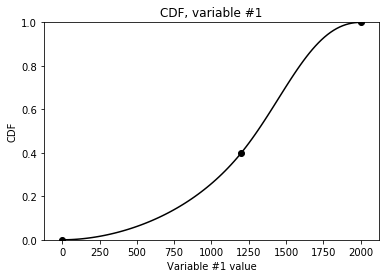

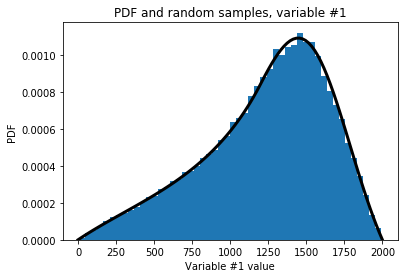

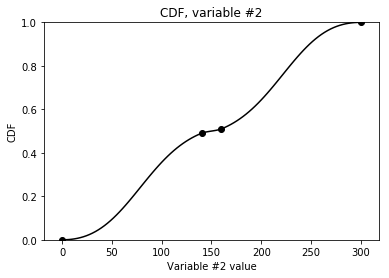

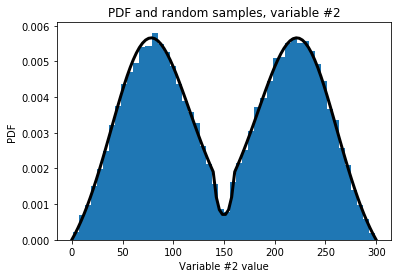

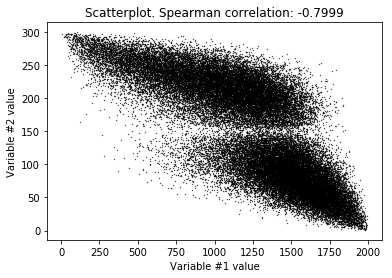

In [4]:
# some plotting
for i in range(dist.nb_vars):
    uv = dist.uv_densities[i]
    _x = np.linspace(uv.x.min(), uv.x.max(), 100)
    _y = uv.cdf(_x)
    _dy = uv.pdf(_x)
    plt.plot(_x, _y, 'k-')
    plt.scatter(uv.x, uv.y, color='k')
    plt.title('CDF, variable #{}'.format(i + 1))
    plt.xlabel('Variable #{} value'.format(i + 1))
    plt.ylabel('CDF')
    plt.ylim([0, 1])
    plt.show()
    plt.hist(x[:,i], bins=50, density=True)
    plt.plot(_x, _dy, 'k-', lw=3)
    plt.xlabel('Variable #{} value'.format(i + 1))
    plt.ylabel('PDF')
    plt.title('PDF and random samples, variable #{}'.format(i + 1))
    plt.show()
plt.scatter(x[:,0], x[:,1], color='k', s=0.1)
plt.title('Scatterplot. Spearman correlation: {:.4f}'.format(spearmanr(x[:,0], x[:,1])[0]))
plt.xlabel('Variable #1 value')
plt.ylabel('Variable #2 value')
plt.show()

# Topic #2 - Optimizing thresholds according to weighted F-measures in variational Bayesian binary classifiers via gradient descent

We consider a variational Bayesian classifier of the form:
$$
\begin{align}
\omega_i &= \mathbf{w}^\top\mathbf{x}_i + {b}, \\
y_i &\sim \text{Bernoulli}(\sigma(\omega_i)),
\end{align}
$$

where $\mathbf{x}$ are the input features (can more generally be features extracted, e.g., from a neural network), $y$ is a binary label, and $\omega$ is the logit.

Denote by $\pmb{\theta}=[{b},\mathbf{w}]$ the model parameters and $\pmb{\psi}$ the variational parameters. Suppose that the variational family is a multivariate normal distribution. Then the posterior predictive distribution of the logits $\omega | \mathbf{x},\pmb{\psi}$ is necessarily normally distributed.

Hence, if we have some holdout data $\mathcal{D}'=\{(\mathbf{x}_i,y_i)\}_{i=1}^n$, the positive and negative examples each consistute a mixture of normals in logit space. Let $F_\mathcal{D'}^0$ ($F_\mathcal{D'}^1$) be the CDF of the mixture of normals in logit space constructed using the negative (positive) examples, and define $\rho$ to be the proportion (prevalence) of positive examples in $\mathcal{D}'$.

For a given threshold $\tau$ in the logit space, the expected value of each quantity in the confusion matrix can be now be expressed as a continuous, differentiable function of $\tau$:

$$
\begin{align}
\text{TNR}(\tau) &= (1-\rho)\cdot F_{\mathcal{D}'}^0(\tau) \\
\text{FPR}(\tau) &= (1-\rho)\cdot (1-F_{\mathcal{D}'}^0(\tau)) \\
\text{FNR}(\tau) &= \rho\cdot F_{\mathcal{D}'}^1(\tau) \\
\text{TPR}(\tau) &= \rho\cdot (1-F_{\mathcal{D}'}^1(\tau))
\end{align}
$$

This allows us to express quantities like expected precision and recall as a continuous, differentiable functions of $\tau$:

$$
\begin{align}
\text{Precision}(\tau) &= \frac{\text{TPR}(\tau)}{\text{TPR}(\tau)+\text{FPR}(\tau)} \\
\text{Recall}(\tau) &= \frac{\text{TPR}(\tau)}{\text{TPR}(\tau)+\text{FNR}(\tau)}
\end{align}
$$

We now consider weighted $F$-measures (i.e., weighted harmonic averages of pecision and recall) of the form:

$$
\begin{align}
F_{w/(1-w)}(\tau) &= \left(\frac{w}{\text{Recall}(\tau)} + \frac{1-w}{\text{Precision}(\tau)}\right)^{-1}
\end{align}
$$

Note that when $w=0.5$, then we recover the $F_1$ score.

For a given choise of $w$, we can find the choice of $\tau$ which optimizes $F_{w/(1-w)}(\tau)$ via a gradient-based solver. We can do this optimization in parallel for as many choices of $w$ as we'd like. In the code below, we use L-BFGS to solve for the optimal thresholds.

In [5]:
def optimize_binary_threshold(class_0, class_1, weight=[0.25, 0.5, 0.75]):
    '''
    Method to optimize binary thresholds according to weighted F-measures.
    '''
    assert all([isinstance(w, float) for w in weight])
    assert all([(w >= 0.) & (w <= 1.) for w in weight])
    weight = sorted(weight)
    threshold_logit = tf.Variable(tf.zeros([len(weight)]))
    threshold = tf.sigmoid(threshold_logit)
    weight_tf = tf.constant(weight, dtype=tf.float32)
    ct_0 = map(int, class_0.components_distribution.batch_shape)[0]
    ct_1 = map(int, class_1.components_distribution.batch_shape)[0]
    prev_1 = float(ct_1) / (ct_0 + ct_1)
    class_01 = [class_0, class_1]
    confusion = {(0, 0): 0., (0, 1): 0., (1, 0): 0., (1, 1): 0.}
    for i in [0, 1]:
        dist = class_01[i]
        _p = (i * prev_1 + (1. - i) * (1. - prev_1))
        cdf = dist.cdf(threshold_logit)
        confusion[(i, 0)] += _p * cdf
        confusion[(i, 1)] += _p * (1. - cdf)
    tnr = confusion[(0, 0)]
    fpr = confusion[(0, 1)]
    fnr = confusion[(1, 0)]
    tpr = confusion[(1, 1)]
    precision = tpr / (tpr + fpr)
    recall = tpr / (tpr + fnr)
    f_measures = 1. / ((1. - weight_tf) / precision + weight_tf / recall)
    f1_score = 1. / (0.5 / precision + 0.5 / recall)
    opt = tf.contrib.opt.ScipyOptimizerInterface(
        loss=-tf.reduce_mean(tf.stack(f_measures)), var_list=[threshold_logit],
        method='l-bfgs-b', options={'maxiter': 1000}
    )
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        opt.minimize(session)
        threshold_logit, threshold, precision, recall, f1_score = session.run(
            [threshold_logit, threshold, precision, recall, f1_score]
        )
    return pd.DataFrame(
        data={
            'weight': weight,
            'threshold_logit': threshold_logit,
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }
    )

In [6]:
# number of observations to sample
nb_obs = 100

# probability that an example is in the negative class
prob_0 = 0.7

# distribution of logits for examples in the negative class
mu_0 = -2.
sigma_0 = 1.5
alpha_0 = 2.5
beta_0 = 2.5

# distribution of logits for examples in the positive class
mu_1 = 2.
sigma_1 = 2.9
alpha_1 = 1.9
beta_1 = 2.1

# generate data
X = []
for i in range(nb_obs):
    x = np.random.uniform()
    if x > prob_0:
        loc = np.random.normal(loc=mu_1, scale=sigma_1)
        scale = np.sqrt(1. / np.random.gamma(shape=alpha_1, scale=beta_1))
        X += [[1, loc, scale]]
    else:
        loc = np.random.normal(loc=mu_0, scale=sigma_0)
        scale = np.sqrt(1. / np.random.gamma(shape=alpha_0, scale=beta_0))
        X += [[0, loc, scale]]
X = np.array(X).astype(np.float32)

In [7]:
# generate mixtures
idx_0 = (X[:, 0] == 0)
idx_1 = ~idx_0
prev_0 = idx_0.sum() / float(idx_0.sum() + idx_1.sum())
prev_1 = 1. - prev_0
class_0 = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[1. / idx_0.sum()] * idx_0.sum()
    ),
    components_distribution=tfd.Normal(
        loc=X[idx_0, 1], scale=X[idx_0, 2]
    )
)
class_1 = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[1. / idx_1.sum()] * idx_1.sum()
    ),
    components_distribution=tfd.Normal(
        loc=X[idx_1, 1], scale=X[idx_1, 2]
    )
)

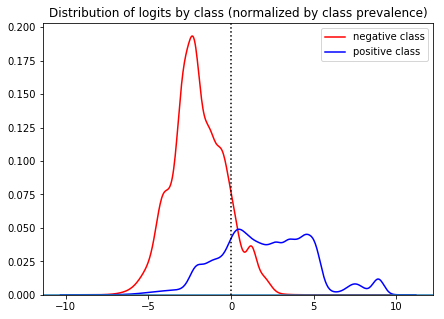

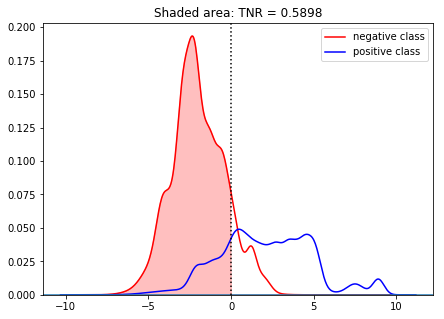

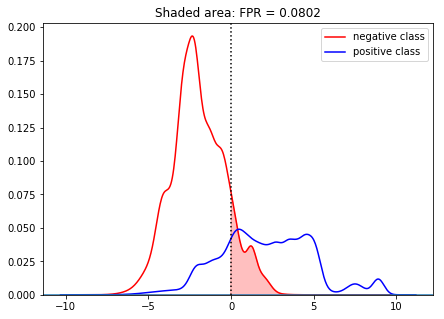

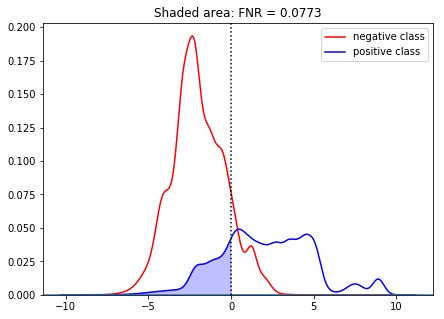

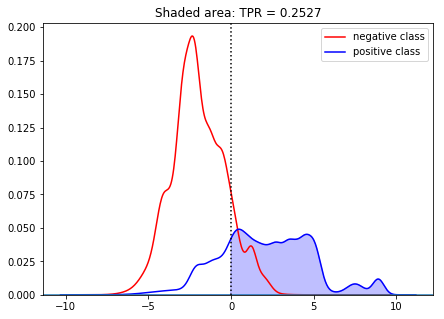

In [8]:
# calculate mixture pdfs for the +/- classes in logit space
x_min = (X[:,1] - 5 * X[:,2]).min()
x_max = (X[:,1] + 5 * X[:,2]).max()
x = np.linspace(x_min, x_max, 500).astype(np.float32)
with tf.Session() as session:
    px_0, px_1 = session.run([prev_0 * class_0.prob(x), prev_1 * class_1.prob(x)])
px = [px_0, px_1]

# plot mixture pdfs for the +/- classes in logit space
plt.figure(figsize=(7, 5))
plt.plot(x, px_0, 'r-', label='negative class')
plt.plot(x, px_1, 'b-', label='positive class')
plt.legend()
plt.axhline(y=0)
plt.axvline(x=0, color='k', ls='dotted', lw=1.5)
plt.ylim([0, 1.05 * max(px_0.max(), px_1.max())])
plt.title('Distribution of logits by class (normalized by class prevalence)')
plt.show()

# demonstrate how confusion matrix quantities can be computed analytically
with tf.Session() as session:
    err_types = {
        (0, 0): ['TNR', prev_0 * session.run(class_0.cdf(0.))],
        (0, 1): ['FPR', prev_0 * session.run(1. - class_0.cdf(0.))],
        (1, 0): ['FNR', prev_1 * session.run(class_1.cdf(0.))],
        (1, 1): ['TPR', prev_1 * session.run(1. - class_1.cdf(0.))]
    }
for i in [0, 1]:
    for j in [0, 1]:
        plt.figure(figsize=(7, 5))
        plt.plot(x, px_0, 'r-', label='negative class')
        plt.plot(x, px_1, 'b-', label='positive class')
        _px = np.copy(px[i])
        idx = (x < 0.)
        color = 'r' if i == 0 else 'b'
        if j == 0:
            idx = ~idx
        _px[idx] = 0.
        p.fill(x, _px, color=color, alpha=0.25)
        plt.legend()
        plt.axhline(y=0)
        plt.axvline(x=0, color='k', ls='dotted', lw=1.5)
        plt.ylim([0, 1.05 * max(px_0.max(), px_1.max())])
        plt.title('Shaded area: {} = {:.4f}'.format(*err_types[(i, j)]))
        plt.show()

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: -0.816827
  Number of iterations: 19
  Number of functions evaluations: 23





Optimizing thresholds for 1001 F-measures completed in 1.0587 seconds.

      f1_score  precision    recall  threshold  threshold_logit  weight
0     0.277535   0.999934  0.161129   0.991374         4.744290     0.0
100   0.635970   0.977468  0.471309   0.905181         2.256163     0.1
200   0.682998   0.937103  0.537302   0.843155         1.681893     0.2
400   0.759838   0.796971  0.726011   0.571551         0.288183     0.4
500   0.762741   0.769205  0.756384   0.517862         0.071480     0.5
700   0.747927   0.691971  0.813729   0.393228        -0.433766     0.7
800   0.689643   0.561954  0.892424   0.198985        -1.392652     0.8
900   0.617752   0.456481  0.955223   0.089339        -2.321732     0.9
1000  0.496240   0.330001  0.999984   0.000335        -8.000007   

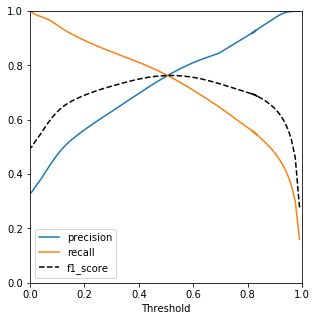

Let's confirm that w=0.5 achieves the maximal F1 score.

     f1_score  precision    recall  threshold  threshold_logit  weight
500  0.762741   0.769205  0.756384   0.517862          0.07148     0.5


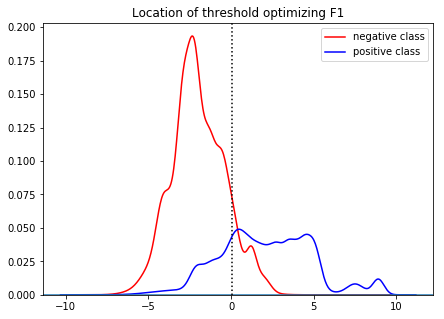

In [9]:
weight = [0.001 * i for i in range(1001)]

start_time = time.time()
cutoffs = optimize_binary_threshold(class_0, class_1, weight=weight)
end_time = time.time()
duration = end_time - start_time

print('\n\n\n\n')
print('Optimizing thresholds for {} F-measures completed in {:.4f} seconds.\n'.format(len(weight), duration))

idx = cutoffs['weight'].isin([0.1 * i for i in range(11)])
print(cutoffs.loc[idx])

plt.figure(figsize=(5, 5))
plt.plot(cutoffs['threshold'], cutoffs['precision'], 'tab:blue')
plt.plot(cutoffs['threshold'], cutoffs['recall'], 'tab:orange')
plt.plot(cutoffs['threshold'], cutoffs['f1_score'], 'k--')
plt.legend()
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Threshold')
plt.show()

print('Let\'s confirm that w=0.5 achieves the maximal F1 score.\n')
# find row index achieving maximal f1 score
idx = map(int, np.where(cutoffs['f1_score'] == cutoffs['f1_score'].max())[0])
print(cutoffs.loc[idx])

plt.figure(figsize=(7, 5))
plt.plot(x, px_0, 'r-', label='negative class')
plt.plot(x, px_1, 'b-', label='positive class')
plt.legend()
plt.axhline(y=0)
i = (cutoffs['weight'] == 0.5)
plt.axvline(x=cutoffs.loc[(i * i.index).sum(), 'threshold_logit'], color='k', ls='dotted', lw=1.5)
plt.ylim([0, 1.05 * max(px_0.max(), px_1.max())])
plt.title('Location of threshold optimizing F1')
plt.show()